In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Path to your dataset zip file in Google Drive
zip_path = '/content/drive/My Drive/Brain_Data_Organised.zip'

# Unzipping the dataset into Colab's working directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/New_Dataset')

# Check if data is extracted properly
os.listdir('/content/New_Dataset')

['Brain_Data_Organised']

In [4]:
data_dir='/content/New_Dataset/Brain_Data_Organised/'

In [5]:
os.listdir(data_dir)

['Train', 'Test']

In [6]:
classes=os.listdir(data_dir+'Train')
classes

['Stroke', 'Normal']

In [7]:
def explore_images(data_dir, folder_type,Class,num_images=2):
  class_file=os.listdir(data_dir + folder_type +'/'+Class)
  print(f'No. of training examples for {Class} :', len(class_file))

In [8]:
for Class in classes:
  explore_images(data_dir,'Train',Class)

No. of training examples for Stroke : 950
No. of training examples for Normal : 1426


In [9]:
for Class in classes:
  explore_images(data_dir,'Test',Class)

No. of training examples for Stroke : 125
No. of training examples for Normal : 125


In [10]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
transform =transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [11]:
data=ImageFolder(data_dir+'Train',transform=transform)

In [12]:
img, label = data[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.9608, -0.9843, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9765, -0.9843, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.9608, -0.9843, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9765, -0.9843, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1

In [13]:
data.classes

['Normal', 'Stroke']

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [15]:

def show_example(img, label):
    print('Label: ', data.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Normal (0)


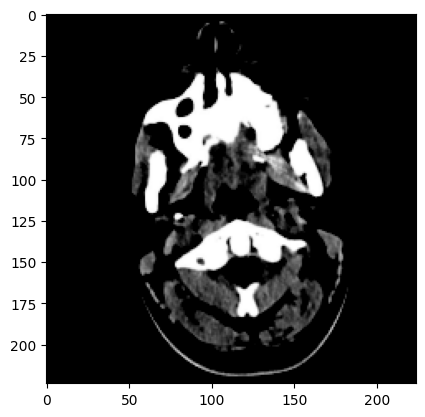

In [16]:
show_example(*data[0])

In [17]:
random_seed = 42
torch.manual_seed(random_seed);

In [18]:
len(data)

2376

In [19]:
from torch.utils.data import random_split

train_size = int(0.8*len(data))
val_size = len(data) - train_size

train_ds, val_ds = random_split(data, [train_size, val_size])

In [20]:
len(train_ds), len(val_ds)

(1900, 476)

In [21]:
# prompt: how to find the distribution of classes in train_ds and val_ds

from collections import Counter

# Count class occurrences in train_ds
train_class_counts = Counter([label for _, label in train_ds])
print("Training set class distribution:")
for class_name, count in train_class_counts.items():
    print(f"Class {data.classes[class_name]}: {count} samples")

# Count class occurrences in val_ds
val_class_counts = Counter([label for _, label in val_ds])
print("\nValidation set class distribution:")
for class_name, count in val_class_counts.items():
    print(f"Class {data.classes[class_name]}: {count} samples")

Training set class distribution:
Class Normal: 1148 samples
Class Stroke: 752 samples

Validation set class distribution:
Class Normal: 278 samples
Class Stroke: 198 samples


In [22]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [23]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

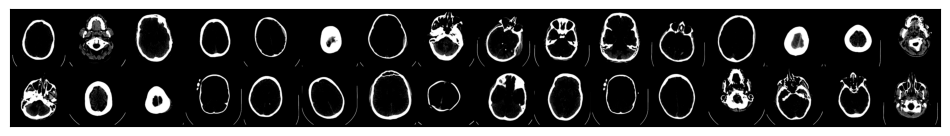

In [24]:
show_batch(train_dl)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
for images, labels in train_dl:
    print(labels)
    break

tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1])


In [27]:
class ConvModel(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    #super(densemodel,self).__init__()
    #nn.flatten()
    self.conv1=nn.Conv2d(3,16,kernel_size=3,padding=1)
    self.conv2=nn.Conv2d(16,32,kernel_size=3,padding=1)
    self.conv3=nn.Conv2d(32,32,kernel_size=3,padding=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
    self.fc1=nn.Linear(32*28*28,1000)
    self.drop1=nn.Dropout(0.5)
    self.fc2=nn.Linear(1000,256)
    self.drop2=nn.Dropout(0.5)
    self.fc3=nn.Linear(256,num_classes)
  def forward(self,x):
    x=self.pool(self.conv1(x))
    x=self.pool(self.conv2(x))
    x=self.pool(self.conv3(x))
    x=x.view(-1,32*28*28)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return x

In [28]:
def train_loop(model, train_dl, val_dl, epochs, lr):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    n_total_steps = len(train_dl)

    # Initialize history dictionary to store metrics for each epoch
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    for epoch in range(epochs):
        # Initialize accumulators for tracking training loss and accuracy
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        model.train()  # Set model to training mode
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total_train += labels.size(0)  # Total samples
            correct_train += (predicted == labels).sum().item()  # Correct predictions

            # Print every 50 steps
            if (i + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        # Calculate average training loss and accuracy for the epoch
        train_loss /= len(train_dl)
        train_accuracy = 100 * correct_train / total_train

        # Track validation loss and accuracy
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # Disable gradient computation
            for images, labels in val_dl:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Accumulate validation loss
                val_loss += loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                total_val += labels.size(0)  # Total samples
                correct_val += (predicted == labels).sum().item()  # Correct predictions

        # Calculate average validation loss and accuracy for the epoch
        val_loss /= len(val_dl)
        val_accuracy = 100 * correct_val / total_val

        # Append metrics to history
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}',
             f"Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%")

    print('Finished Training')
    return history


In [29]:
# Define data augmentation for training data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Randomly crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5), # Flip horizontally with 50% probability
    transforms.RandomRotation(15),         # Rotate images by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define transforms for validation data
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply data augmentation only to the training dataset
train_ds.dataset.transform = train_transforms  # Overwrite the transform for training data
val_ds.dataset.transform = val_transforms      # Overwrite the transform for validation data

# Create DataLoaders
train_loader2 = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader2 = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [30]:
lr=0.001
epochs=50
optim=torch.optim.SGD

In [31]:
model=ConvModel(len(classes)).to(device)

In [32]:
model

ConvModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1000, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=256, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [41]:
history=train_loop(model,train_dl,val_dl,50,lr)

Epoch [1/50], Step [50/60], Loss: 0.6370
Epoch [1/50], Training Loss: 0.6684 Training Accuracy: 60.37%, Validation Loss: 0.6704, Validation Accuracy: 58.40%
Epoch [2/50], Step [50/60], Loss: 0.7117
Epoch [2/50], Training Loss: 0.6597 Training Accuracy: 60.42%, Validation Loss: 0.6633, Validation Accuracy: 59.03%
Epoch [3/50], Step [50/60], Loss: 0.5782
Epoch [3/50], Training Loss: 0.6522 Training Accuracy: 61.16%, Validation Loss: 0.6573, Validation Accuracy: 59.87%
Epoch [4/50], Step [50/60], Loss: 0.6662
Epoch [4/50], Training Loss: 0.6442 Training Accuracy: 61.74%, Validation Loss: 0.6537, Validation Accuracy: 60.08%
Epoch [5/50], Step [50/60], Loss: 0.6416
Epoch [5/50], Training Loss: 0.6381 Training Accuracy: 62.53%, Validation Loss: 0.6494, Validation Accuracy: 59.66%
Epoch [6/50], Step [50/60], Loss: 0.6454
Epoch [6/50], Training Loss: 0.6305 Training Accuracy: 62.53%, Validation Loss: 0.6463, Validation Accuracy: 59.66%
Epoch [7/50], Step [50/60], Loss: 0.5938
Epoch [7/50], Tra

In [34]:
model2=ConvModel(len(classes)).to(device)

In [35]:
model2

ConvModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1000, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=256, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [45]:
history2=train_loop(model2,train_loader2,val_loader2,epochs,lr)

Epoch [1/50], Step [50/60], Loss: 0.6670
Epoch [1/50], Training Loss: 0.6805 Training Accuracy: 58.32%, Validation Loss: 0.6764, Validation Accuracy: 58.40%
Epoch [2/50], Step [50/60], Loss: 0.6499
Epoch [2/50], Training Loss: 0.6680 Training Accuracy: 60.42%, Validation Loss: 0.6736, Validation Accuracy: 58.40%
Epoch [3/50], Step [50/60], Loss: 0.6658
Epoch [3/50], Training Loss: 0.6648 Training Accuracy: 60.42%, Validation Loss: 0.6717, Validation Accuracy: 58.40%
Epoch [4/50], Step [50/60], Loss: 0.7283
Epoch [4/50], Training Loss: 0.6619 Training Accuracy: 60.42%, Validation Loss: 0.6689, Validation Accuracy: 58.40%
Epoch [5/50], Step [50/60], Loss: 0.6661
Epoch [5/50], Training Loss: 0.6582 Training Accuracy: 60.42%, Validation Loss: 0.6669, Validation Accuracy: 58.40%
Epoch [6/50], Step [50/60], Loss: 0.7018
Epoch [6/50], Training Loss: 0.6562 Training Accuracy: 60.63%, Validation Loss: 0.6633, Validation Accuracy: 59.24%
Epoch [7/50], Step [50/60], Loss: 0.7282
Epoch [7/50], Tra

In [37]:
def plot_losses(history):
    train_losses = [x for x in history['train_loss']]
    val_losses = [x for x in history['val_loss']]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

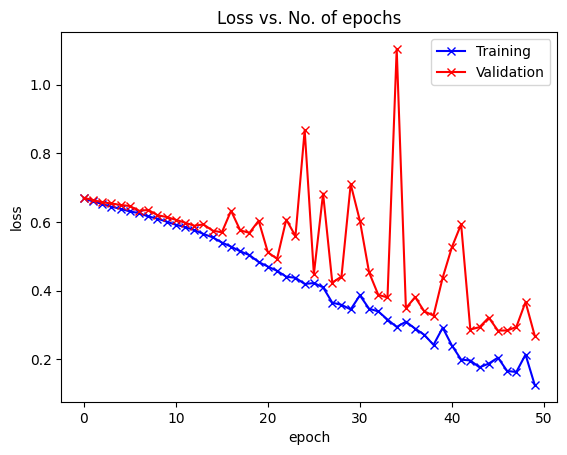

In [42]:
plot_losses(history)

In [39]:
def plot_accuracies(history):
    val_accuracies = [x for x in history['val_accuracy']]
    train_accuracy=[x for x in history['train_accuracy']]
    plt.plot(train_accuracy, '-bx')
    plt.plot(val_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

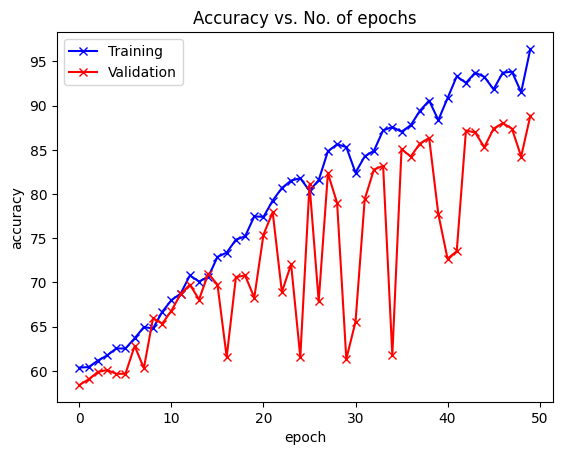

In [43]:
plot_accuracies(history)

In [46]:
torch.save(model.state_dict(), 'ProjetCnn.pth')

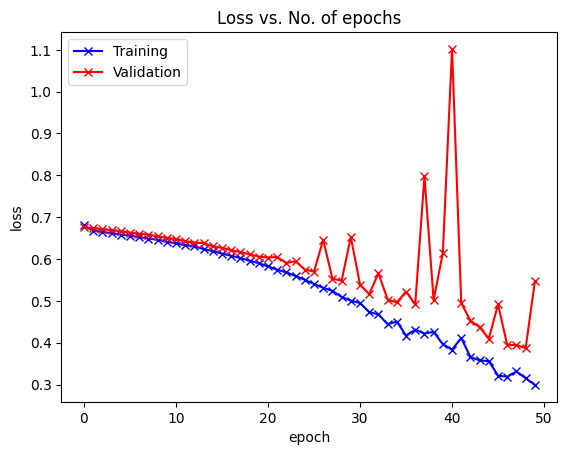

In [47]:
plot_losses(history2)

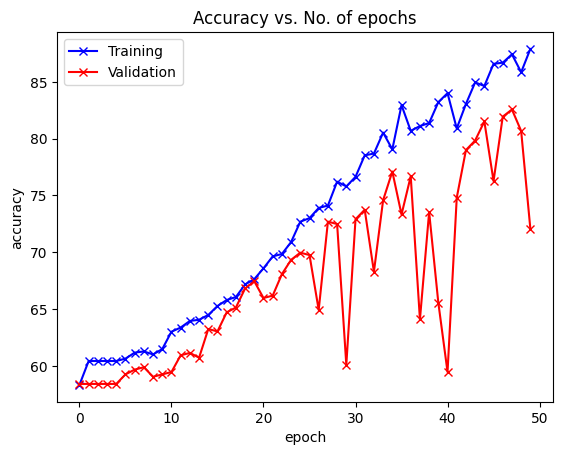

In [48]:
plot_accuracies(history2)

In [49]:
test_data=ImageFolder(data_dir+'Test',transform=transform)

In [50]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return data.classes[preds[0].item()]

Label: Normal , Predicted: Normal


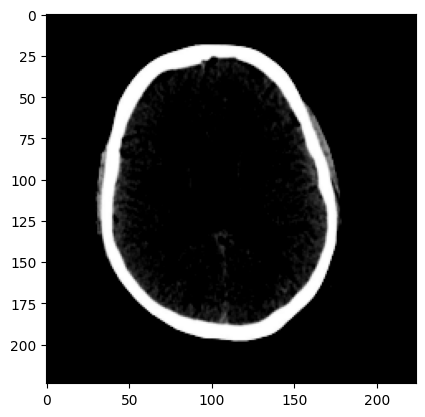

In [51]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', data.classes[label], ', Predicted:', predict_image(img, model))

Label: Normal , Predicted: Normal


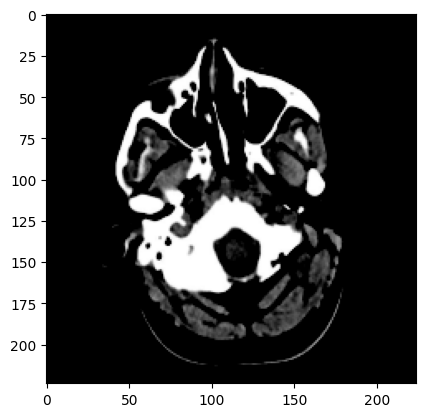

In [52]:
img, label = test_data[10]
plt.imshow(img.permute(1, 2, 0))
print('Label:', data.classes[label], ', Predicted:', predict_image(img, model))

In [53]:
@torch.no_grad()
def evaluate_test_data(model, test_dl):
    model.eval()  # Set model to evaluation mode
    criterion = nn.CrossEntropyLoss()  # Loss function

    test_loss = 0.0
    correct = 0
    total = 0

    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Accumulate test loss
        test_loss += loss.item()

        # Calculate test accuracy
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)  # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    # Calculate average test loss and accuracy
    test_loss /= len(test_dl)
    test_accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return {"test_loss": test_loss, "test_accuracy": test_accuracy}


In [55]:
test_loader = DataLoader(test_data, batch_size=32)
test_metrics=evaluate_test_data(model,test_loader)

Test Loss: 0.3572, Test Accuracy: 86.80%
